In [1]:
# set cwd and solver
import os
import cobra
cobra.Configuration().solver = "gurobi"
os.chdir('C:/Users/prins/GitHub/Human1_RPE-PR') 

In [2]:
# load all models in \cs_mods\July2023 folder by cycling through names
from cobra.io import read_sbml_model    
from pathlib import Path
import pandas as pd

# do not change directory but still go to the folder with the models
folder = Path().cwd() / "cs_mods" / "July2023"
model_list = []
for file in folder.glob("*.xml"):  
    model = read_sbml_model(file)
    model.id = file.stem # remove .xml 
    model.name = file.stem # remove .xml
    model_list.append(model)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-03


No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized


In [3]:
# load old combined RPE_PR models
mod_RPE_PR = read_sbml_model(Path().cwd() / "models" / "mod_RPE_PR.xml")
mod_RPE_PR.id = 'RPE_PR_old'
mod_RPE_PR.name = 'RPE_PR_old'
mod_Human1_Human1 = read_sbml_model(Path().cwd() / "models" /  "mod_Human1_Human1.xml")
mod_Human1_Human1.id = 'RPE_PR_control_old'
mod_Human1_Human1.name = 'RPE_PR_control_old'
mod = read_sbml_model(Path().cwd() / 'models/Human-GEM.xml')
mod.id = 'Human1_old'
mod.name = 'Human1_old'

# add old models to model_list
model_list = model_list + [mod,mod_RPE_PR]

# check out model_list
model_list

[<Model Human-GEM_28062023 at 0x1617430d510>,
 <Model mod_RPE_PRcone_Liang at 0x1617cfd4b20>,
 <Model mod_RPE_PRcone_Liang_singlePR at 0x1613ee673a0>,
 <Model mod_RPE_PRcone_Liang_singleRPE at 0x16149d4e6b0>,
 <Model mod_RPE_PRcone_Lukowski at 0x16157b7b430>,
 <Model mod_RPE_PRcone_Lukowski_singlePR at 0x161618db160>,
 <Model mod_RPE_PRcone_Lukowski_singleRPE at 0x16165c46bf0>,
 <Model mod_RPE_PRcontrol at 0x161613036a0>,
 <Model mod_RPE_PRrod_Liang at 0x161990e6e00>,
 <Model mod_RPE_PRrod_Liang_singlePR at 0x161de877c10>,
 <Model mod_RPE_PRrod_Liang_singleRPE at 0x161e1cdec50>,
 <Model mod_RPE_PRrod_Lukowski at 0x161e75fa770>,
 <Model mod_RPE_PRrod_Lukowski_singlePR at 0x16198ded1b0>,
 <Model mod_RPE_PRrod_Lukowski_singleRPE at 0x161f1717a00>,
 <Model Human1_old at 0x16198e448b0>,
 <Model RPE_PR_old at 0x1616c167160>]

In [4]:
# modify models
# load blood exchange bounds

# for all models in the list set objective function (ATP hydrolysis, in PR for combined models)
for m in model_list:
    if 'MAR03964_PR' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_PR'
    elif 'MAR03964_RPE' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_RPE'
    elif 'MAR03964' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964'
    else:
        print('no ATP hydrolysis reaction (MAR03964) in model: ' + m.id)

# list combined and single models
combined_models = [m for m in model_list if 'single' not in m.id and 'Human' not in m.id]
single_models = [m for m in model_list if 'single' in m.id]
Human1_models = [m for m in model_list if 'Human' in m.id]

# close PR exchange in combined models and open RPE exchange (efflux)
for m in combined_models:
    for r in [r for r in m.reactions if len(r.products) == 0 ]:           # close all exchange reactions
        r.bounds=(0,0)
    for r in [r for r in m.reactions if len(r.products) == 0 if '_RPE' in r.id]:           # open efflux for RPE exchange reactions
        r.bounds=(0,1000) 

# only allow efflux exchange in single models
for m in single_models:
    for r in [r for r in m.reactions if len(r.products) == 0 ]:           # close all exchange reactions
        r.bounds=(0,1000)

# for Human1 models, open efflux
for m in [m for m in model_list if 'Human' in m.id]:
    for r in [r for r in m.reactions if len(r.products) == 0]:           # open efflux for RPE exchange reactions
        r.bounds=(0,1000)

In [5]:
# set exchange bounds for blood
from src.modify_model import set_exchange_bounds
ex_bounds = {'MAR09048':(-3.51,1000),'MAR09034':(-4.18,1000),'MAR09135':(7.25,1000)}
# MAR09048: oxygen
# MAR09034: glucose
# MAR09135: lactate

results_dict = {}
for m in model_list:
    set_exchange_bounds(m, ex_bounds)
    m.optimize()
    results_dict[m.id] = m.objective.value
df1 = pd.DataFrame(results_dict, index = ['max ATP hydrolysis (pmol/s/mm^2)']).T
df1

,max ATP hydrolysis (pmol/s/mm^2)
Human-GEM_28062023,24.7325
mod_RPE_PRcone_Liang,23.9000
mod_RPE_PRcone_Liang_singlePR,11.1350
mod_RPE_PRcone_Liang_singleRPE,23.9000
mod_RPE_PRcone_Lukowski,24.7325
mod_RPE_PRcone_Lukowski_singlePR,22.2350
mod_RPE_PRcone_Lukowski_singleRPE,23.9000
mod_RPE_PRcontrol,24.7325
mod_RPE_PRrod_Liang,23.9000
mod_RPE_PRrod_Liang_singlePR,13.9100


In [6]:
model_list[-5]

Name,mod_RPE_PRrod_Lukowski
Memory address,161e75fa770
Number of metabolites,10678
Number of reactions,14592
Number of genes,2188
Number of groups,149
Objective expression,1.0*MAR03964_PR - 1.0*MAR03964_PR_reverse_e8402
Compartments,"c_RPE, r_RPE, e_RPE, m_RPE, x_RPE, g_RPE, l_RPE, n_RPE, i_RPE, e_RPE_PR, c_PR, x_PR, m_PR, g_PR, r_PR, l_PR, i_PR"


In [7]:
# This cell is disabled because it takes a long time to run.
# The results are saved in the folder 'results/unlimited_lactate' and can be loaded from there.
# To enable this cell, remove the comment symbol (#) at the beginning of each line

# FLUX VARIABILITY ANALYSIS

# ex_bounds = [{'MAR09048':(-3.51,1000),'MAR09034':(-4.18,1000),'MAR09135':(-1000,1000)},\
#             {'MAR09048':(0,1000),'MAR09034':(-4.18,1000),'MAR09135':(-1000,1000)},\
#             {'MAR09048':(-1000,1000),'MAR09034':(-4.18,1000),'MAR09135':(-1000,1000)}]

# MAR09048: oxygen
# MAR09034: glucose
# MAR09135: lactate

# from cobra.flux_analysis import flux_variability_analysis

# fba = {}
# fva = {}
# fva_loopless = {}

# for bounds in ex_bounds:
#     m = model_list[-5]
#     set_exchange_bounds(m, bounds)
#     fba[str(bounds)] = pd.DataFrame(m.optimize().fluxes)
#     print('fba done with bounds: ' + str(bounds) + ' for model: ' + m.id)
#     fva[str(bounds)] = flux_variability_analysis(m, loopless=False)
#     print('fva done with bounds: ' + str(bounds) + ' for model: ' + m.id)
#     fva_loopless[str(bounds)] = flux_variability_analysis(m, loopless=True)
#     print('fva_loopless done with bounds: ' + str(bounds) + ' for model: ' + m.id)

# # pickle fba, fva and fva_loopless
# from pathlib import Path
# # create folder if it does not exist
# Path(Path().cwd() / 'results' / 'unlimited_lactate').mkdir(parents=True, exist_ok=True)

# import pickle
# with open(Path().cwd() / 'results' / 'unlimited_lactate' / 'fba.pkl', 'wb') as f:
#     pickle.dump(fba, f)
# with open(Path().cwd() / 'results' / 'unlimited_lactate' / 'fva.pkl', 'wb') as f:
#     pickle.dump(fva, f)
# with open(Path().cwd() / 'results' / 'unlimited_lactate' / 'fva_loopless.pkl', 'wb') as f:
#     pickle.dump(fva_loopless, f)

In [8]:
# Load FBA and FVA results for unlimited lactate production (output from cell above)

import pickle
with open(Path().cwd() / 'results' / 'unlimited_lactate' / 'fba.pkl', 'rb') as f:
    fba = pickle.load(f)
with open(Path().cwd() / 'results' / 'unlimited_lactate' / 'fva.pkl', 'rb') as f:
    fva = pickle.load(f)
with open(Path().cwd() / 'results' / 'unlimited_lactate' / 'fva_loopless.pkl', 'rb') as f:
    fva_loopless = pickle.load(f)   

In [9]:
# fba
df_fba = pd.concat(fba, axis=1)
df_fba = df_fba.rename(columns={'fluxes': 'fba'})

# fva
df_fva = pd.concat(fva, axis=1)
df_fva = df_fva.rename(columns={'minimum': 'min', 'maximum': 'max'})

# loopless fva
df_fva_loopless = pd.concat(fva_loopless, axis=1)
df_fva_loopless = df_fva_loopless.rename(columns={'minimum': 'min_loopless', 'maximum': 'max_loopless'})

# make one big df with fba, fva, loopless fva
df = pd.concat([df_fba, df_fva, df_fva_loopless], axis=1)

# resort columns based on first layer of multiindex per first multi index level
df = df.reindex(sorted(df.columns), axis=1)

# for first layer multiindex
for i in range(len(df.columns.levels[0])):
    # sort second layer multiindex ['fba', 'min', 'max', 'min_loopless', 'max_loopless']
    df = df.reindex(['fba', 'min', 'min_loopless','max','max_loopless'], axis=1, level=1)


In [10]:
# sort rows based on absolute value sizes in min_loopless and max_loopless columns
# get absolute values for loopless columns
# select columns with 'min_loopless' or 'max_loopless' in the second level of the column index
min_max_loopless = df.loc[:, df.columns.get_level_values(1).isin(['min_loopless', 'max_loopless'])]
# transform to absolute values
min_max_loopless = min_max_loopless.abs()
# get sum of absolute values for each row
min_max_loopless['sum'] = min_max_loopless.sum(axis=1)

In [11]:
# make rxn_df
from src.get_info import make_rxn_df
rxn_df = make_rxn_df(model_list[-5])

In [63]:
# fuse rxn_df and df keep rows sorted based on df 
df_combined = pd.concat([rxn_df, df], axis=1)
# sort df using min_max_loopless['sum']
df_combined = df_combined.reindex(min_max_loopless.sort_values('sum', ascending=False).index)

# save df_combined as excel in results folder / fva_lactate_unlimited
df_combined.to_excel('results/unlimited_lactate/unlimited_lactate.xlsx')
df_combined

,cell,lb,ub,kegg.reaction,rhea,sbo,reactome,bigg.reaction,tcdb,metanetx.reaction,...,"({'MAR09048': (-3.51, 1000), 'MAR09034': (-4.18, 1000), 'MAR09135': (-1000, 1000)}, fba)","({'MAR09048': (-3.51, 1000), 'MAR09034': (-4.18, 1000), 'MAR09135': (-1000, 1000)}, min)","({'MAR09048': (-3.51, 1000), 'MAR09034': (-4.18, 1000), 'MAR09135': (-1000, 1000)}, min_loopless)","({'MAR09048': (-3.51, 1000), 'MAR09034': (-4.18, 1000), 'MAR09135': (-1000, 1000)}, max)","({'MAR09048': (-3.51, 1000), 'MAR09034': (-4.18, 1000), 'MAR09135': (-1000, 1000)}, max_loopless)","({'MAR09048': (0, 1000), 'MAR09034': (-4.18, 1000), 'MAR09135': (-1000, 1000)}, fba)","({'MAR09048': (0, 1000), 'MAR09034': (-4.18, 1000), 'MAR09135': (-1000, 1000)}, min)","({'MAR09048': (0, 1000), 'MAR09034': (-4.18, 1000), 'MAR09135': (-1000, 1000)}, min_loopless)","({'MAR09048': (0, 1000), 'MAR09034': (-4.18, 1000), 'MAR09135': (-1000, 1000)}, max)","({'MAR09048': (0, 1000), 'MAR09034': (-4.18, 1000), 'MAR09135': (-1000, 1000)}, max_loopless)"
MAR11276_RPE_PR,PR,-1000.0,1000.0,,,SBO:0000185,,PMTCRNtr,,,...,0.0,-1000.0,-1000.0,1000.0,1000.0,0.0,-1000.0,-1000.0,1000.0,1000.0
MAR00104_PR,PR,-1000.0,1000.0,,,SBO:0000176,,C161CPT22,,MNXR96388,...,0.0,-1000.0,-1000.0,1000.0,1000.0,0.0,-1000.0,-1000.0,1000.0,1000.0
MAR08998_PR,PR,-1000.0,1000.0,,,SBO:0000185,,q10tm,,MNXR97066,...,0.0,-1000.0,-1000.0,1000.0,1000.0,0.0,-1000.0,0.0,1000.0,1000.0
MAR08997_PR,PR,-1000.0,1000.0,,,SBO:0000185,,q10h2tc,,MNXR103390,...,0.0,-1000.0,-1000.0,1000.0,1000.0,0.0,-1000.0,-1000.0,1000.0,0.0
MAR04875_PR_RPE,RPE,-1000.0,1000.0,,,SBO:0000185,,,,MNXR102230,...,0.0,-1000.0,-1000.0,1000.0,1000.0,0.0,-1000.0,-1000.0,1000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAR04217_RPE,RPE,0.0,1000.0,,,SBO:0000627,,EX_HC02205_e,,MNXR98169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MAR04230_RPE,RPE,0.0,1000.0,,,SBO:0000627,,EX_HC02213_e,,MNXR98174,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MAR04337_RPE,RPE,0.0,1000.0,,,SBO:0000627,,EX_23cump_e,,MNXR98002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MAR04339_RPE,RPE,0.0,1000.0,,,SBO:0000627,,EX_3ump_e,,MNXR98057,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
# select oxygen and lactate exchange reactions, and PR ATP hydrolysis reaction

# 'MAR03964_PR' PR ATP hydrolysis
# 'MAR09048_RPE' oxygen
# 'MAR09135_RPE' lactate

df_combined_selection = df_combined.loc[['MAR03964_PR', 'MAR09048_RPE', 'MAR09135_RPE'], :]
df_combined_selection = df_combined.loc[['MAR03964_PR', 'MAR09135_RPE'], :]
df_combined_selection


,cell,lb,ub,kegg.reaction,rhea,sbo,reactome,bigg.reaction,tcdb,metanetx.reaction,...,"({'MAR09048': (-3.51, 1000), 'MAR09034': (-4.18, 1000), 'MAR09135': (-1000, 1000)}, fba)","({'MAR09048': (-3.51, 1000), 'MAR09034': (-4.18, 1000), 'MAR09135': (-1000, 1000)}, min)","({'MAR09048': (-3.51, 1000), 'MAR09034': (-4.18, 1000), 'MAR09135': (-1000, 1000)}, min_loopless)","({'MAR09048': (-3.51, 1000), 'MAR09034': (-4.18, 1000), 'MAR09135': (-1000, 1000)}, max)","({'MAR09048': (-3.51, 1000), 'MAR09034': (-4.18, 1000), 'MAR09135': (-1000, 1000)}, max_loopless)","({'MAR09048': (0, 1000), 'MAR09034': (-4.18, 1000), 'MAR09135': (-1000, 1000)}, fba)","({'MAR09048': (0, 1000), 'MAR09034': (-4.18, 1000), 'MAR09135': (-1000, 1000)}, min)","({'MAR09048': (0, 1000), 'MAR09034': (-4.18, 1000), 'MAR09135': (-1000, 1000)}, min_loopless)","({'MAR09048': (0, 1000), 'MAR09034': (-4.18, 1000), 'MAR09135': (-1000, 1000)}, max)","({'MAR09048': (0, 1000), 'MAR09034': (-4.18, 1000), 'MAR09135': (-1000, 1000)}, max_loopless)"
MAR03964_PR,PR,0.00,1000.0,R00086,"[13066, 13065]",SBO:0000176,,ATPM,,,...,25.91,25.910,25.910,25.91,25.91,8.36,8.360,8.360,8.36,8.36
MAR09135_RPE,RPE,7.25,1000.0,,,SBO:0000627,,EX_lac__L_e,,,...,1.34,-595.048,-595.048,4.85,4.85,8.36,-586.624,-586.624,8.36,8.36


Text(0.5, 1.0, 'Maximum fluxes (loopless)')

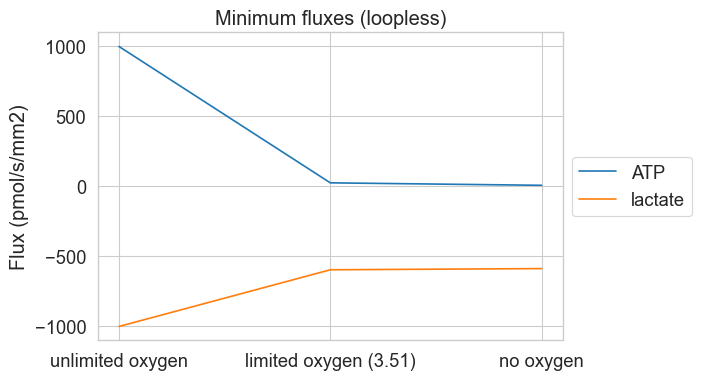

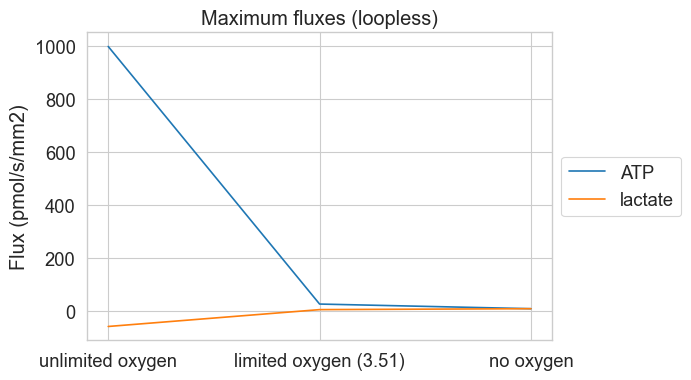

In [75]:
# select min loopless columns only (columns containing 'min_loopless')
df_min_loopless = df_combined_selection[[c for c in df_combined_selection.columns if 'min_loopless' in c]]
df_max_loopless = df_combined_selection[[c for c in df_combined_selection.columns if 'max_loopless' in c]]

df_max_loopless.transpose()

# line plot df_min_loopless
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# plot
fig, ax = plt.subplots(figsize=(6, 4))
df_min_loopless.transpose().plot(ax=ax, legend=False)
ax.set_ylabel('Flux (pmol/s/mm2)')

# rotate x-axis labels
for item in ax.get_xticklabels():
    item.set_rotation(0)

# set x labels
ax.set_xticks([0,1,2])
ax.set_xticklabels(['unlimited oxygen','limited oxygen (3.51)','no oxygen'])

# add legend
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# change legend labels
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['ATP', 'lactate'], loc='center left', bbox_to_anchor=(1, 0.5))
# title plot
plt.title('Minimum fluxes (loopless)')

# plot
fig, ax = plt.subplots(figsize=(6, 4))
df_max_loopless.transpose().plot(ax=ax, legend=False)
ax.set_ylabel('Flux (pmol/s/mm2)')

# rotate x-axis labels
for item in ax.get_xticklabels():
    item.set_rotation(0)

# set x labels
ax.set_xticks([0,1,2])
ax.set_xticklabels(['unlimited oxygen','limited oxygen (3.51)','no oxygen'])

# add legend
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# change legend labels
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['ATP', 'lactate'], loc='center left', bbox_to_anchor=(1, 0.5))
# title plot
plt.title('Maximum fluxes (loopless)')


In [85]:
# plot minimum and maximum lines
# select MAR03964_PR data
df_min_max_loopless_ATP = df_min_max_loopless.filter(like='MAR03964_PR', axis=0)
# select MAR09135_RPE data
df_min_max_loopless_lactate = df_min_max_loopless.filter(like='MAR09135_RPE', axis=0)


,"({'MAR09048': (-1000, 1000), 'MAR09034': (-4.18, 1000), 'MAR09135': (-1000, 1000)}, min_loopless)","({'MAR09048': (-1000, 1000), 'MAR09034': (-4.18, 1000), 'MAR09135': (-1000, 1000)}, max_loopless)","({'MAR09048': (-3.51, 1000), 'MAR09034': (-4.18, 1000), 'MAR09135': (-1000, 1000)}, min_loopless)","({'MAR09048': (-3.51, 1000), 'MAR09034': (-4.18, 1000), 'MAR09135': (-1000, 1000)}, max_loopless)","({'MAR09048': (0, 1000), 'MAR09034': (-4.18, 1000), 'MAR09135': (-1000, 1000)}, min_loopless)","({'MAR09048': (0, 1000), 'MAR09034': (-4.18, 1000), 'MAR09135': (-1000, 1000)}, max_loopless)"
MAR09135_RPE,-1000.0,-58.869831,-595.048,4.85,-586.624,8.36


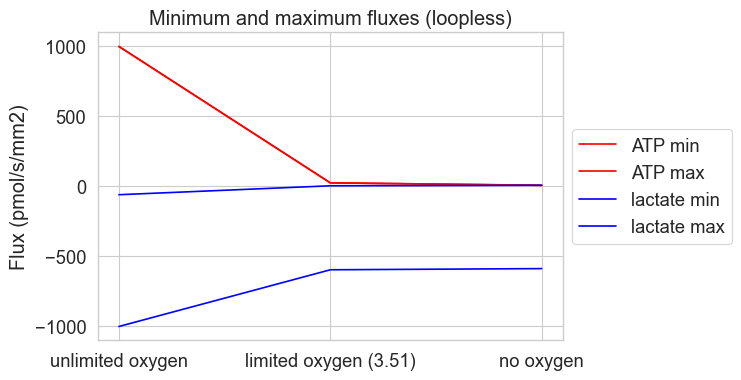

In [92]:
# select min and max loopless columns only (columns containing 'min_loopless' or 'max_loopless')
df_min_max_loopless = df_combined_selection[[c for c in df_combined_selection.columns if 'min_loopless' in c or 'max_loopless' in c]]

# create plot
fig, ax = plt.subplots(figsize=(6, 4))

# plot minimum and maximum lines

# select MAR03964_PR data (ATP)
df_min_max_loopless_ATP = df_min_max_loopless.filter(like='MAR03964_PR', axis=0)
# select MAR09135_RPE data (lactate)
df_min_max_loopless_lactate = df_min_max_loopless.filter(like='MAR09135_RPE', axis=0)

df_min_max_loopless_ATP.filter(like='min_loopless').transpose().plot(ax=ax, legend=False, color='r')
df_min_max_loopless_ATP.filter(like='max_loopless').transpose().plot(ax=ax, legend=False, color='r')
df_min_max_loopless_lactate.filter(like='min_loopless').transpose().plot(ax=ax, legend=False, color='b')
df_min_max_loopless_lactate.filter(like='max_loopless').transpose().plot(ax=ax, legend=False, color='b')

# fill with colour between blue lines


# set y label
ax.set_ylabel('Flux (pmol/s/mm2)')

# rotate x-axis labels
for item in ax.get_xticklabels():
    item.set_rotation(0)

# set x labels
ax.set_xticks([0,1,2])
ax.set_xticklabels(['unlimited oxygen','limited oxygen (3.51)','no oxygen'])

# add legend
ax.legend(['ATP min', 'ATP max', 'lactate min', 'lactate max'], loc='center left', bbox_to_anchor=(1, 0.5))

# title plot
plt.title('Minimum and maximum fluxes (loopless)')


# show plot
plt.show()

In [228]:
from src.modify_model import create_permutation_dicts

ex_bounds = {'MAR09048':[(-3.51,-3.51)],\
        'MAR09034':[(0,0),(-1,-1),(-2,-2),(-3,-3),(-4,-4),(-5,-5),(-6,-6),(-7,-7),(-7,-7),(-8,-8),(-9,9),(-10,-10)],\
        'MAR09135':[(10,10),(9,9),(8,8),(7,7),(6,6),(5,5),(4,4),(3,3),(2,2),(1,1),(0,0),(-1,-1),(-2,-2),(-3,-3),(-4,-4),(-5,-5),(-6,-6),(-7,-7),(-7,-7),(-8,-8),(-9,9),(-10,-10)]}

ex_labels = {'glucose':[(-3.51,-3.51)],\
        'oxygen':[(0,0),(-1,-1),(-2,-2),(-3,-3),(-4,-4),(-5,-5),(-6,-6),(-7,-7),(-7,-7),(-8,-8),(-9,9),(-10,-10)],\
        'lactate':[(10,10),(9,9),(8,8),(7,7),(6,6),(5,5),(4,4),(3,3),(2,2),(1,1),(0,0),(-1,-1),(-2,-2),(-3,-3),(-4,-4),(-5,-5),(-6,-6),(-7,-7),(-7,-7),(-8,-8),(-9,9),(-10,-10)]}

In [232]:
bounds = create_permutation_dicts(ex_bounds)
labels = create_permutation_dicts(ex_labels)

objective_values = []
for i in range(len(bounds)):
    model = set_exchange_bounds(model,bounds[i])
    fba = model.optimize()
    objective_values.append(fba.objective_value)

objective_values_df = pd.DataFrame(objective_values)

# add labels
objective_values_df['labels'] = labels
objective_values_df


c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\u

,0,labels
0,NaN,"{'glucose': (-3.51, -3.51), 'oxygen': (0, 0), ..."
1,NaN,"{'glucose': (-3.51, -3.51), 'oxygen': (0, 0), ..."
2,NaN,"{'glucose': (-3.51, -3.51), 'oxygen': (0, 0), ..."
3,NaN,"{'glucose': (-3.51, -3.51), 'oxygen': (0, 0), ..."
4,NaN,"{'glucose': (-3.51, -3.51), 'oxygen': (0, 0), ..."
...,...,...
259,37.55,"{'glucose': (-3.51, -3.51), 'oxygen': (-10, -1..."
260,37.55,"{'glucose': (-3.51, -3.51), 'oxygen': (-10, -1..."
261,37.55,"{'glucose': (-3.51, -3.51), 'oxygen': (-10, -1..."
262,37.55,"{'glucose': (-3.51, -3.51), 'oxygen': (-10, -1..."


In [233]:
b_df = pd.DataFrame()
# create list of b
for i in range(len(objective_values_df)):
    b = pd.DataFrame(objective_values_df['labels'][i]).iloc[0].to_frame().T
    b_df = pd.concat([b_df,b],axis=0)

b_df.reset_index(inplace=True,drop=True)

pd.concat([b_df,objective_values_df],axis=1)

# cobmine b_df and objective_values
df = pd.concat([b_df, objective_values], axis=1)
# select columns for heathmap (oxygen, lactate, and objective_value)
df2 = df[['oxygen', 'lactate', 'objective_value']]
df2

,glucose,oxygen,lactate
0,-3.51,0.0,10.0
1,-3.51,0.0,9.0
2,-3.51,0.0,8.0
3,-3.51,0.0,7.0
4,-3.51,0.0,6.0
...,...,...,...
259,-3.51,-10.0,-7.0
260,-3.51,-10.0,-7.0
261,-3.51,-10.0,-8.0
262,-3.51,-10.0,-9.0


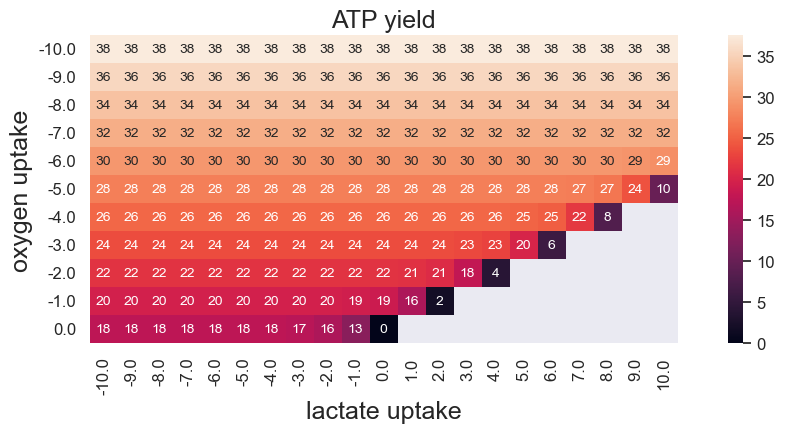

In [225]:
df_reshaped = df2.pivot_table(index='oxygen', columns='lactate', values='objective_value')
df_reshaped
# heatmap

fig, ax = plt.subplots(figsize=(13,4))
sns.heatmap(df_reshaped, annot=True, fmt='.0f', cmap='rocket', annot_kws={"size": 10})
plt.title('ATP yield')
plt.xlabel('lactate uptake')
plt.ylabel('oxygen uptake')
# make boxes square
plt.gca().set_aspect('equal', adjustable='box')
#  annotation font size
plt.tick_params(labelsize=12)
# size bar font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)

In [245]:
from src.modify_model import create_permutation_dicts



# create a function to create stepwise tuple lists like the ones above
def create_stepwise_tuples(start,stop,step):
        """
        this function creates a list of tuples with the same start and stop values, but with a stepwise increase in the values

        Parameters
        ----------
        start : float
                start value
        stop : float
                stop value
        step : float
                step size

        Returns
        -------
        list
                list of tuples with the same start and stop values, but with a stepwise increase in the values

        """
        import numpy as np
        return [(i,i) for i in np.arange(start,stop+step,step)]

# test the function
create_stepwise_tuples(0,10,0.5)

[(0.0, 0.0),
 (0.5, 0.5),
 (1.0, 1.0),
 (1.5, 1.5),
 (2.0, 2.0),
 (2.5, 2.5),
 (3.0, 3.0),
 (3.5, 3.5),
 (4.0, 4.0),
 (4.5, 4.5),
 (5.0, 5.0),
 (5.5, 5.5),
 (6.0, 6.0),
 (6.5, 6.5),
 (7.0, 7.0),
 (7.5, 7.5),
 (8.0, 8.0),
 (8.5, 8.5),
 (9.0, 9.0),
 (9.5, 9.5),
 (10.0, 10.0)]

In [246]:
bounds_oxygen = create_stepwise_tuples(-8,1,0.5)
bounds_lactate = create_stepwise_tuples(-4,10,0.1)
ex_bounds = {'MAR09048':[(-3.51,-3.51)],\
        'MAR09034':bounds_oxygen,\
        'MAR09135':bounds_lactate}

ex_labels = {'glucose':[(-3.51,-3.51)],\
        'oxygen':bounds_oxygen,\
        'lactate':bounds_lactate}

bounds = create_permutation_dicts(ex_bounds)
labels = create_permutation_dicts(ex_labels)

objective_values = []
for i in range(len(bounds)):
    model = set_exchange_bounds(model,bounds[i])
    fba = model.optimize()
    objective_values.append(fba.objective_value)



c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\u

TypeError: cannot concatenate object of type '<class 'list'>'; only Series and DataFrame objs are valid

In [247]:
objective_values_df = pd.DataFrame(objective_values)

objective_values_df

,0
0,33.55
1,33.55
2,33.55
3,33.55
4,33.55
...,...
2674,NaN
2675,NaN
2676,NaN
2677,NaN


In [248]:
objective_values_df = pd.DataFrame(objective_values)
# add labels
objective_values_df['labels'] = labels
objective_values_df

,0,labels
0,33.55,"{'glucose': (-3.51, -3.51), 'oxygen': (-8.0, -..."
1,33.55,"{'glucose': (-3.51, -3.51), 'oxygen': (-8.0, -..."
2,33.55,"{'glucose': (-3.51, -3.51), 'oxygen': (-8.0, -..."
3,33.55,"{'glucose': (-3.51, -3.51), 'oxygen': (-8.0, -..."
4,33.55,"{'glucose': (-3.51, -3.51), 'oxygen': (-8.0, -..."
...,...,...
2674,NaN,"{'glucose': (-3.51, -3.51), 'oxygen': (1.0, 1...."
2675,NaN,"{'glucose': (-3.51, -3.51), 'oxygen': (1.0, 1...."
2676,NaN,"{'glucose': (-3.51, -3.51), 'oxygen': (1.0, 1...."
2677,NaN,"{'glucose': (-3.51, -3.51), 'oxygen': (1.0, 1...."


In [251]:
objective_values_df = pd.DataFrame(objective_values)
# add labels
objective_values_df['labels'] = labels
objective_values_df
b_df = pd.DataFrame()
# create list of b
for i in range(len(objective_values_df)):
    b = pd.DataFrame(objective_values_df['labels'][i]).iloc[0].to_frame().T
    b_df = pd.concat([b_df,b],axis=0)

b_df

,glucose,oxygen,lactate
0,-3.51,-8.0,-4.0
0,-3.51,-8.0,-3.9
0,-3.51,-8.0,-3.8
0,-3.51,-8.0,-3.7
0,-3.51,-8.0,-3.6
...,...,...,...
0,-3.51,1.0,9.6
0,-3.51,1.0,9.7
0,-3.51,1.0,9.8
0,-3.51,1.0,9.9


In [264]:
b_df.reset_index(inplace=True,drop=True)
b_df

pd.concat([b_df,objective_values_df],axis=1)

# rename column 0 to 'objective_value'
objective_values_df.rename(columns={0:'objective_value'},inplace=True)

# merge b_df and objective_values_df
df = pd.concat([b_df,objective_values_df],axis=1)

# select columns for heathmap (oxygen, lactate, and objective_value)
df2 = df[['oxygen', 'lactate', 'objective_value']]
df2

,oxygen,lactate,objective_value
0,-8.0,-4.0,33.55
1,-8.0,-3.9,33.55
2,-8.0,-3.8,33.55
3,-8.0,-3.7,33.55
4,-8.0,-3.6,33.55
...,...,...,...
2674,1.0,9.6,NaN
2675,1.0,9.7,NaN
2676,1.0,9.8,NaN
2677,1.0,9.9,NaN


In [265]:
df_reshaped = df2.pivot_table(index='oxygen', columns='lactate', values='objective_value')
df_reshaped

lactate,-4.0,-3.9,-3.8,-3.7,-3.6,-3.5,-3.4,-3.3,-3.2,-3.1,...,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9,10.0
oxygen,,,,,,,,,,,,,,,,,,,,,
-8.0,33.55,33.55,33.55,33.55,33.55,33.55,33.55,33.55,33.55,33.55,...,33.550,33.550,33.550,33.550,33.550,33.550,33.550,33.550,33.550,33.550
-7.5,32.55,32.55,32.55,32.55,32.55,32.55,32.55,32.55,32.55,32.55,...,32.550,32.550,32.550,32.550,32.550,32.550,32.550,32.550,32.550,32.550
-7.0,31.55,31.55,31.55,31.55,31.55,31.55,31.55,31.55,31.55,31.55,...,31.550,31.550,31.550,31.550,31.550,31.550,31.550,31.550,31.550,31.550
-6.5,30.55,30.55,30.55,30.55,30.55,30.55,30.55,30.55,30.55,30.55,...,30.550,30.550,30.550,30.550,30.545,30.495,30.445,30.395,30.345,30.295
-6.0,29.55,29.55,29.55,29.55,29.55,29.55,29.55,29.55,29.55,29.55,...,29.245,29.195,29.145,29.095,29.045,28.995,28.945,28.895,28.845,28.795
-5.5,28.55,28.55,28.55,28.55,28.55,28.55,28.55,28.55,28.55,28.55,...,27.745,27.695,27.645,27.595,27.545,27.495,27.445,27.395,26.400,25.000
-5.0,27.55,27.55,27.55,27.55,27.55,27.55,27.55,27.55,27.55,27.55,...,22.600,21.200,19.800,18.400,17.000,15.600,14.200,12.800,11.400,10.000
-4.5,26.55,26.55,26.55,26.55,26.55,26.55,26.55,26.55,26.55,26.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-4.0,25.55,25.55,25.55,25.55,25.55,25.55,25.55,25.55,25.55,25.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


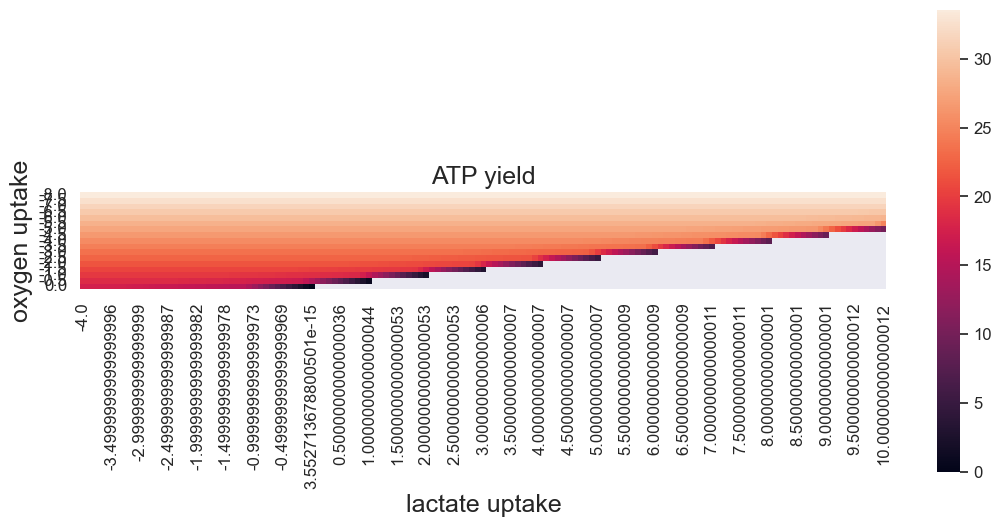

In [270]:
df_reshaped = df2.pivot_table(index='oxygen', columns='lactate', values='objective_value')
# heatmap
fig, ax = plt.subplots(figsize=(13,6))
sns.heatmap(df_reshaped, annot=False, cmap='rocket', annot_kws={"size": 10})
plt.title('ATP yield')
plt.xlabel('lactate uptake')
plt.ylabel('oxygen uptake')
# make boxes square
plt.gca().set_aspect('equal', adjustable='box')
#  annotation font size
plt.tick_params(labelsize=12)
# size bar font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)

# round up to 2 decimals (ticks)
#ax.set_xticklabels(np.round(ax.get_xticks(),2));


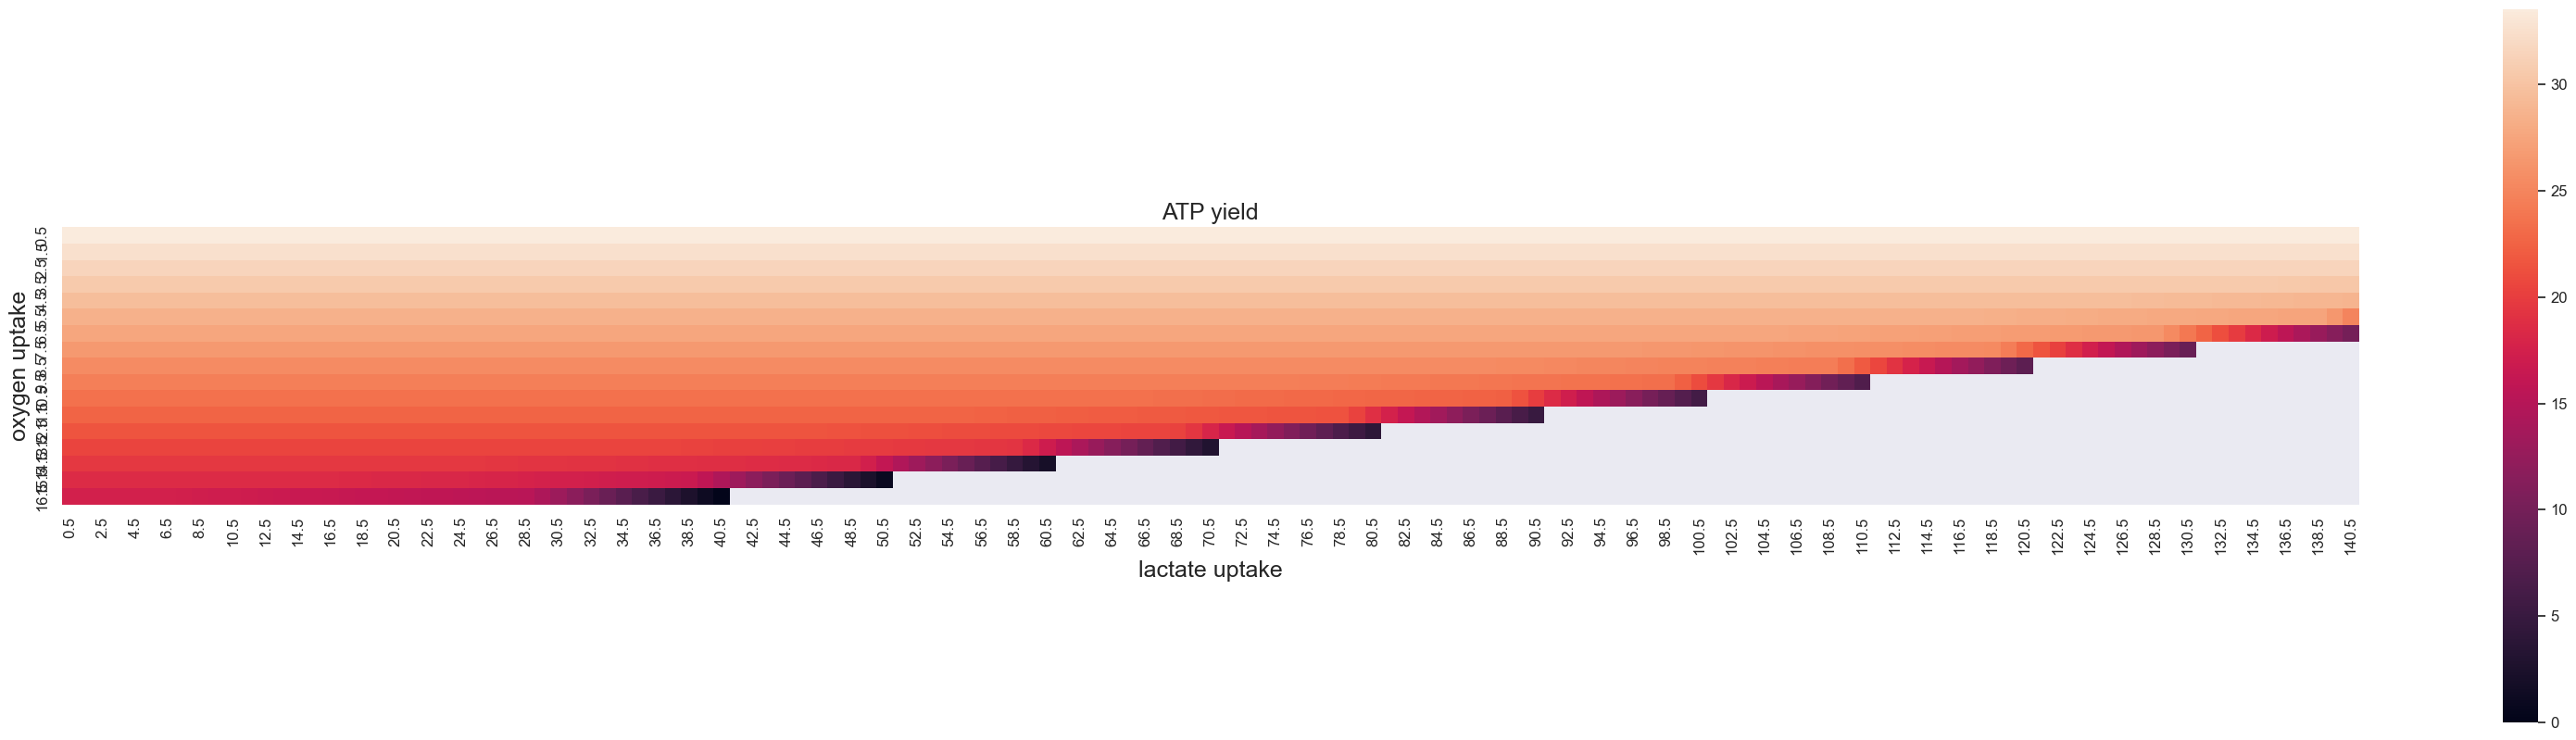

In [277]:
import numpy as np

df_reshaped = df2.pivot_table(index='oxygen', columns='lactate', values='objective_value')
df_reshaped

# heatmap
fig, ax = plt.subplots(figsize=(40,10))
sns.heatmap(df_reshaped, annot=False, cmap='rocket', annot_kws={"size": 10})
plt.title('ATP yield')
plt.xlabel('lactate uptake')
plt.ylabel('oxygen uptake')
# make boxes square
plt.gca().set_aspect('equal', adjustable='box')
#  annotation font size
plt.tick_params(labelsize=12)
# size bar font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)

# format tick labels to display only one number after decimal point
xticklabels = [f'{x:.1f}' for x in ax.get_xticks()]
yticklabels = [f'{y:.1f}' for y in ax.get_yticks()]
ax.set_xticklabels(xticklabels)
ax.set_yticklabels(yticklabels)

plt.show()

In [282]:
bounds_oxygen = create_stepwise_tuples(-8,1,0.5)
bounds_lactate = create_stepwise_tuples(-4,10,0.5)
ex_bounds = {'MAR09048':[(-3.51,-3.51)],\
        'MAR09034':bounds_oxygen,\
        'MAR09135':bounds_lactate}

ex_labels = {'glucose':[(-3.51,-3.51)],\
        'oxygen':bounds_oxygen,\
        'lactate':bounds_lactate}

bounds = create_permutation_dicts(ex_bounds)
labels = create_permutation_dicts(ex_labels)

objective_values = []
for i in range(len(bounds)):
    model = set_exchange_bounds(model,bounds[i])
    fba = model.optimize()
    objective_values.append(fba.objective_value)

objective_values_df = pd.DataFrame(objective_values)
# add labels
objective_values_df['labels'] = labels
objective_values_df
b_df = pd.DataFrame()
# create list of b
for i in range(len(objective_values_df)):
    b = pd.DataFrame(objective_values_df['labels'][i]).iloc[0].to_frame().T
    b_df = pd.concat([b_df,b],axis=0)

b_df

c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\u

,glucose,oxygen,lactate
0,-3.51,-8.0,-4.0
0,-3.51,-8.0,-3.5
0,-3.51,-8.0,-3.0
0,-3.51,-8.0,-2.5
0,-3.51,-8.0,-2.0
...,...,...,...
0,-3.51,1.0,8.0
0,-3.51,1.0,8.5
0,-3.51,1.0,9.0
0,-3.51,1.0,9.5


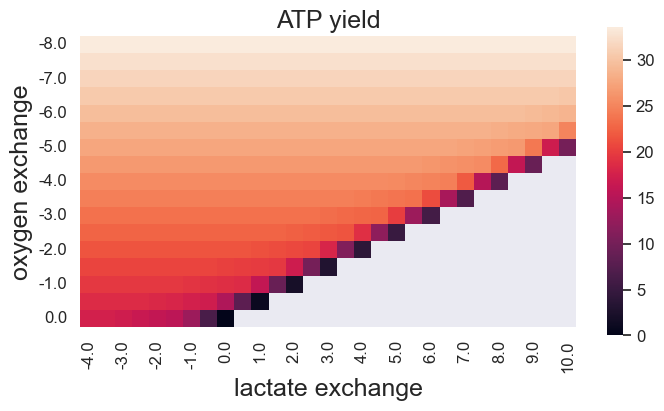

In [287]:
bounds_oxygen = create_stepwise_tuples(-8,1,0.5)
bounds_lactate = create_stepwise_tuples(-4,10,0.5)
ex_bounds = {'MAR09048':[(-3.51,-3.51)],\
        'MAR09034':bounds_oxygen,\
        'MAR09135':bounds_lactate}

ex_labels = {'glucose':[(-3.51,-3.51)],\
        'oxygen':bounds_oxygen,\
        'lactate':bounds_lactate}

bounds = create_permutation_dicts(ex_bounds)
labels = create_permutation_dicts(ex_labels)

objective_values = []
for i in range(len(bounds)):
    model = set_exchange_bounds(model,bounds[i])
    fba = model.optimize()
    objective_values.append(fba.objective_value)

objective_values_df = pd.DataFrame(objective_values)
# add labels
objective_values_df['labels'] = labels
objective_values_df
b_df = pd.DataFrame()
# create list of b
for i in range(len(objective_values_df)):
    b = pd.DataFrame(objective_values_df['labels'][i]).iloc[0].to_frame().T
    b_df = pd.concat([b_df,b],axis=0)

b_df

b_df.reset_index(inplace=True,drop=True)
pd.concat([b_df,objective_values_df],axis=1)

# rename column 0 to 'objective_value'
objective_values_df.rename(columns={0:'objective_value'},inplace=True)

# merge b_df and objective_values_df
df = pd.concat([b_df,objective_values_df],axis=1)

# select columns for heathmap (oxygen, lactate, and objective_value)
df2 = df[['oxygen', 'lactate', 'objective_value']]

df_reshaped = df2.pivot_table(index='oxygen', columns='lactate', values='objective_value')
# heatmap
fig, ax = plt.subplots(figsize=(8,4))
sns.heatmap(df_reshaped, annot=False, cmap='rocket', annot_kws={"size": 10})
plt.title('ATP yield')
plt.xlabel('lactate exchange')
plt.ylabel('oxygen exchange')
# make boxes square
plt.gca().set_aspect('equal', adjustable='box')
#  annotation font size
plt.tick_params(labelsize=12)
# size bar font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)

# round up to 2 decimals (ticks)
#ax.set_xticklabels(np.round(ax.get_xticks(),2));


In [288]:
bounds_oxygen = create_stepwise_tuples(-7,1,0.2)
bounds_lactate = create_stepwise_tuples(-2,10,0.2)
ex_bounds = {'MAR09048':[(-3.51,-3.51)],\
        'MAR09034':bounds_oxygen,\
        'MAR09135':bounds_lactate}

ex_labels = {'glucose':[(-3.51,-3.51)],\
        'oxygen':bounds_oxygen,\
        'lactate':bounds_lactate}

bounds = create_permutation_dicts(ex_bounds)
labels = create_permutation_dicts(ex_labels)

objective_values = []
for i in range(len(bounds)):
    model = set_exchange_bounds(model,bounds[i])
    fba = model.optimize()
    objective_values.append(fba.objective_value)

objective_values_df = pd.DataFrame(objective_values)
# add labels
objective_values_df['labels'] = labels
objective_values_df
b_df = pd.DataFrame()
# create list of b
for i in range(len(objective_values_df)):
    b = pd.DataFrame(objective_values_df['labels'][i]).iloc[0].to_frame().T
    b_df = pd.concat([b_df,b],axis=0)

b_df

b_df.reset_index(inplace=True,drop=True)
pd.concat([b_df,objective_values_df],axis=1)

# rename column 0 to 'objective_value'
objective_values_df.rename(columns={0:'objective_value'},inplace=True)

# merge b_df and objective_values_df
df = pd.concat([b_df,objective_values_df],axis=1)

# select columns for heathmap (oxygen, lactate, and objective_value)
df2 = df[['oxygen', 'lactate', 'objective_value']]

df_reshaped = df2.pivot_table(index='oxygen', columns='lactate', values='objective_value')
# heatmap
fig, ax = plt.subplots(figsize=(8,4))
sns.heatmap(df_reshaped, annot=False, cmap='rocket', annot_kws={"size": 10})
plt.title('ATP yield')
plt.xlabel('lactate exchange')
plt.ylabel('oxygen exchange')
# make boxes square
plt.gca().set_aspect('equal', adjustable='box')
#  annotation font size
plt.tick_params(labelsize=12)
# size bar font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)

# round up to 2 decimals (ticks)
#ax.set_xticklabels(np.round(ax.get_xticks(),2));


c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\u

In [284]:
b_df

,glucose,oxygen,lactate
0,-3.51,-8.0,-4.0
0,-3.51,-8.0,-3.5
0,-3.51,-8.0,-3.0
0,-3.51,-8.0,-2.5
0,-3.51,-8.0,-2.0
...,...,...,...
0,-3.51,1.0,8.0
0,-3.51,1.0,8.5
0,-3.51,1.0,9.0
0,-3.51,1.0,9.5
